In [1]:
%load_ext autoreload
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch
from torch import nn
import torch.functional as F
import torchvision
import tqdm
from IPython.display import clear_output
from torch.utils.data import DataLoader, Dataset
from collections import defaultdict

from sklearn.metrics import accuracy_score, silhouette_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn import datasets

from joblib import Parallel, delayed
from multiprocessing import cpu_count

from utils import *
from train_utils import *
from mlp import MLP
from train_utils import get_grad_params

from IPython.core.debugger import set_trace

%autoreload 2

device = torch.device('cuda:0')
N_CPU = cpu_count()

In [159]:
mnist_train = torchvision.datasets.MNIST('./data', download=True, train=True,
                                         transform=torchvision.transforms.ToTensor())

mnist_test = torchvision.datasets.MNIST('./data', download=True, train=False,
                                       transform=torchvision.transforms.ToTensor())

# torchvision.datasets.


d = 28**2
n_classes = 10
n_classes_range = np.arange(n_classes)

# baseline random embedding
inpt_test = mnist_test.data.view(-1,d).to(device).type(torch.float32) / 255.
target_test = mnist_test.targets.to(device)
y_test = to_numpy(target_test)

inpt_train = mnist_train.data.view(-1,d).to(device).type(torch.float32) / 255.
target_train = mnist_train.targets.to(device)
y_train = to_numpy(target_train)

mean = inpt_train.mean(0, keepdims=True)
std = inpt_train.std(0, keepdims=True)

inpt_train -= mean
inpt_test -= mean

# std = inpt_train.std(0, keepdims=True)
# std[std == 0] += 1e-5
# inpt_train /= std
# inpt_test /= std

In [4]:
!nvidia-smi

Tue Oct 24 21:17:50 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.125.06   Driver Version: 525.125.06   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    Off  | 00000000:01:00.0  On |                  Off |
| 32%   66C    P2   299W / 300W |  42747MiB / 49140MiB |     99%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [183]:
cov_matrix = (inpt_train.T @ inpt_train) / (inpt_train.shape[0]-1)
cov_matrix += torch.eye(cov_matrix.shape[0], dtype=cov_matrix.dtype, device=cov_matrix.device)*1e-2

w,e = torch.linalg.eig(cov_matrix)
w = w.real
e = e.real

inpt_train_pca = inpt_train.clone()
inpt_test_pca = inpt_test.clone()

inpt_train_pca = (inpt_train_pca @ e) / w.unsqueeze(0) 
inpt_test_pca = (inpt_test_pca @ e) / w.unsqueeze(0) 

In [13]:
!nvidia-smi

Fri Oct 27 17:34:35 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.125.06   Driver Version: 525.125.06   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    Off  | 00000000:01:00.0  On |                  Off |
| 30%   57C    P2    98W / 300W |   1390MiB / 49140MiB |     36%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

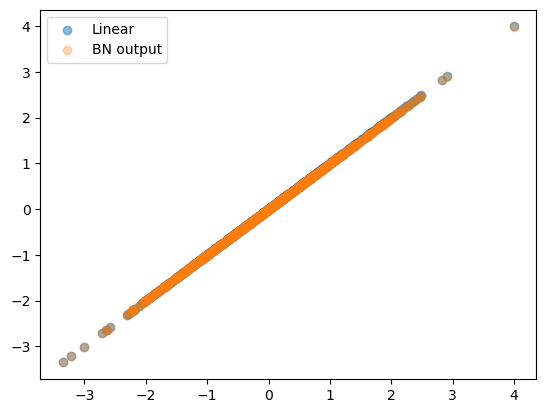

In [158]:
X = torch.randn(1000,1)
X, sort_args = X.sort()

bn = nn.BatchNorm1d(1, affine=False, track_running_stats=False)

delta = torch.rand(1)*15 + torch.randn_like(X)*1e-3 # delta_c + eps
# foo = torch.sigmoid(X + delta) # approx 0.5 + 0.25*(x + delta)
foo = X + delta # approx 0.5 + 0.25*(x + delta)


X_ = bn(foo)

plt.scatter(to_numpy(X).flatten(), to_numpy(X), alpha=0.5, label='Linear')
# plt.scatter(to_numpy(X).flatten(), to_numpy(torch.sigmoid(X)), alpha=0.5, label='Sigmoid')
# plt.scatter(to_numpy(X).flatten(), 0.25*to_numpy(X) + 0.5, alpha=0.5, label='Sigm. linear approx')
plt.scatter(to_numpy(X).flatten(), to_numpy(X_), alpha=0.3, label='BN output')
plt.legend()
plt.show()

In [136]:
X.mean(), X.std()

(tensor(-0.0039), tensor(1.0096))

In [137]:
X_.mean(), X_.std()

(tensor(-4.7326e-08), tensor(1.0004))

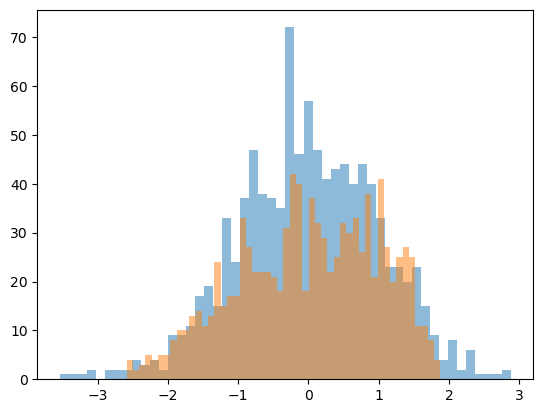

In [138]:
plt.hist(to_numpy(X)[:,0], bins=50, alpha=0.5)
# plt.hist(to_numpy(foo)[:,0], bins=50, alpha=0.5)
plt.hist(to_numpy(X_)[:,0], bins=50, alpha=0.5)

plt.show()

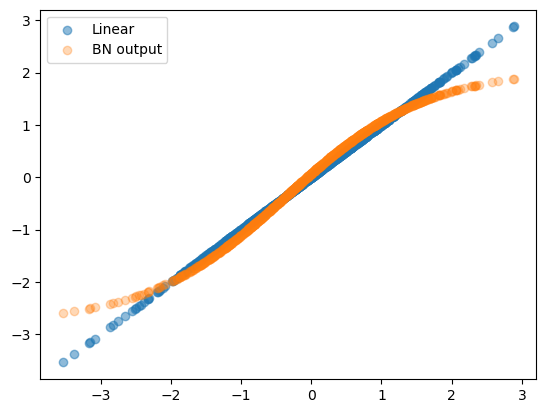

In [95]:
X_sorted, sort_args = X.sort(dim=0)